# Bayesian Linear Regression

Benjamin T. Vincent, [@inferenceLab](https://twitter.com/inferencelab)

## Introduction
This notebook is intended as a very brief introduction into some of the concepts used in the Bayesian approach. We will look at an example which everyone is familiar with, linear regression, in order to focus upon the concepts rather than the model itself.

This is an example of "descriptive modelling" where in the majority of cases, linear modelling is meant to _describe_ data that we have observed as opposed to _explaining_ it. We will explore explanatory models in the next notebooks.

In [1]:
using Distributions, StatsPlots, Turing

## Simulate some fake data

In [2]:
β₀ = 4  # intercept
β₁ = -2  # slope
σ = 0.5  # observation noise
N = 20;  # sample size

In [3]:
linear_regression(x, β₀, β₁) = β₀ + β₁ * x;

In [4]:
x = rand(Normal(0, 1), N)
y = rand.(Normal.(linear_regression.(x, β₀, β₁), σ));

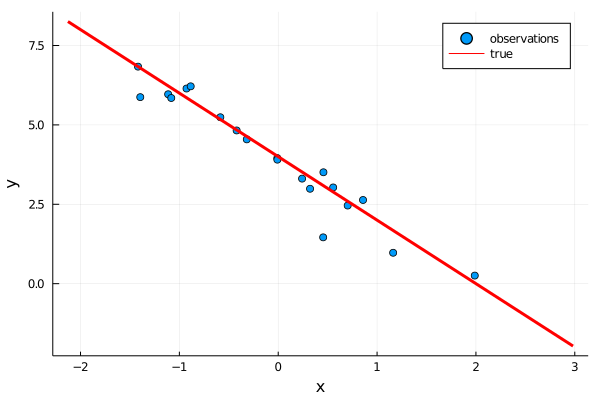

In [5]:
scatter(x, y, xlabel="x", ylabel="y", label="observations")
LinRange(minimum(x)*1.5, maximum(x)*1.5, 50) |>
    x -> plot!(x, linear_regression.(x, β₀, β₁), label="true", lw=3, color=:red)

## Bayesian linear regression model
Wonder at the beauty of how minimal this Bayesian model of linear regression is! 

In [6]:
@model function bayesian_logistic_regression(x, y)
    β₀ ~ Normal(0, 1)
    β₁ ~ Normal(0, 1)
    σ ~ TruncatedNormal(0, 1, 0, Inf)
    @. y ~ Normal(linear_regression(x, β₀, β₁), σ)
end;

## Sample from the prior

In [7]:
# sample from the prior
prior = sample(bayesian_logistic_regression(x, y), Prior(), 5_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


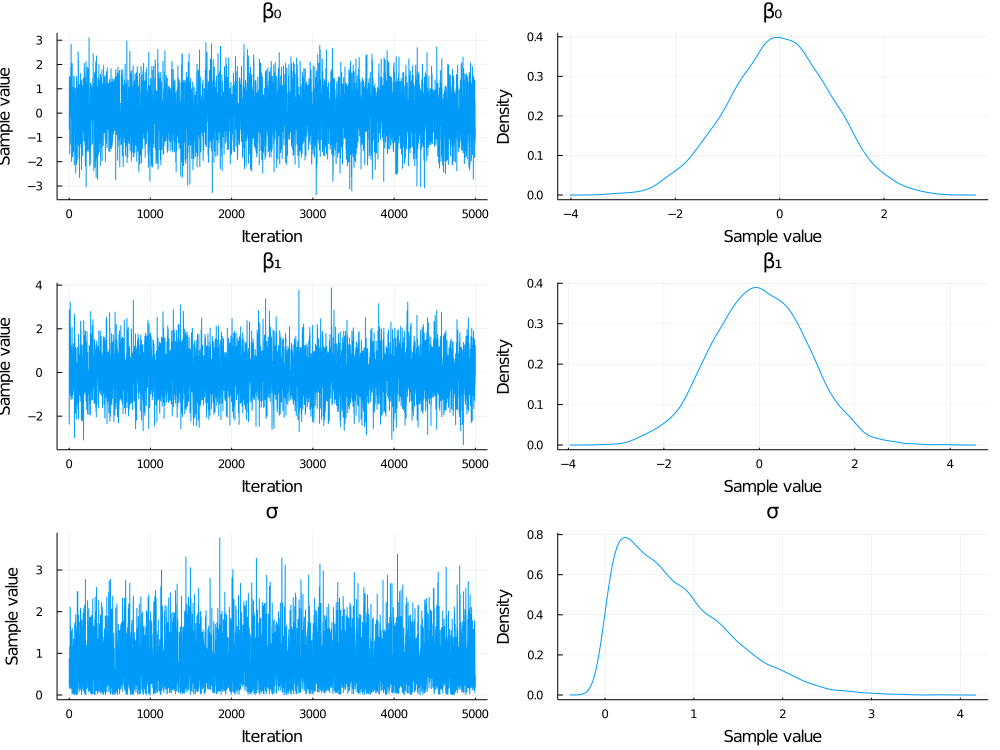

In [8]:
plot(prior)

## Sample from the posterior

In [9]:
posterior = sample(bayesian_logistic_regression(x, y), NUTS(1000, .95), MCMCThreads(), 2000, 4)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/XLLTf/src/inference/hmc.jl:188


Chains MCMC chain (2000×15×4 Array{Float64,3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 2000
parameters        = β₀, β₁, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          β₀    3.8025    0.1244     0.0014    0.0015   5992.0417    0.9999
          β₁   -1.9514    0.1391     0.0016    0.0018   5948.7713    1.0001
           σ    0.5449    0.0997     0.0011    0.0016   5178.4420    1.0005

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          β₀    3.5497    3.7243    3.8057    3.8842    4.0390
      

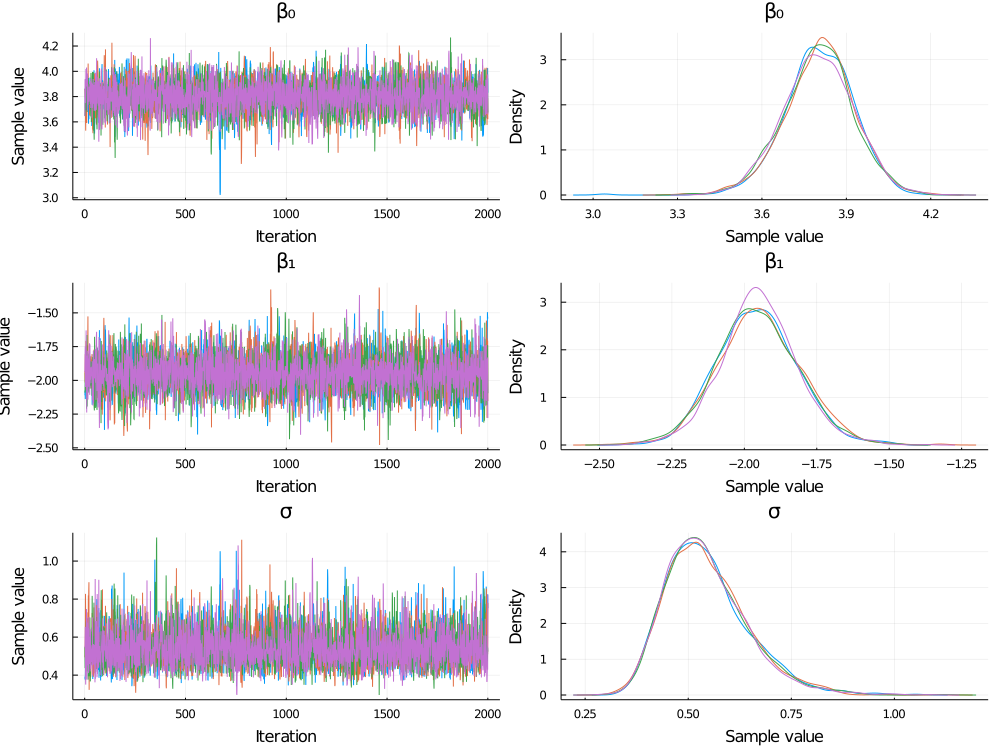

In [10]:
plot(posterior)

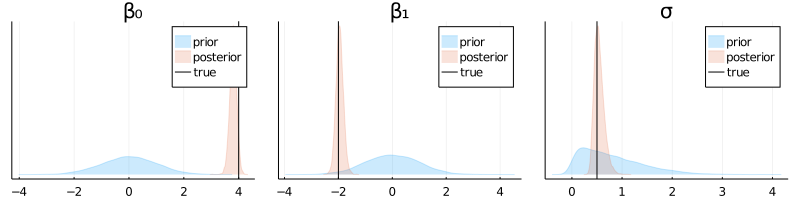

In [15]:
plot(layout=(1, 3), size=(800, 200))
for (i, param) in enumerate([:β₀, :β₁, :σ])
    density!(prior["$param"], subplot=i, label="prior", fill=true, alpha=0.2)
    density!(vec(Array(posterior["$param"])), subplot=i, label="posterior", fill=true, alpha=0.2)
    vline!([eval(param)], label="true", subplot=i, colour=:black)
    plot!(subplot=i, title="$param", yticks=false)
end
plot!()

## Posterior prediction

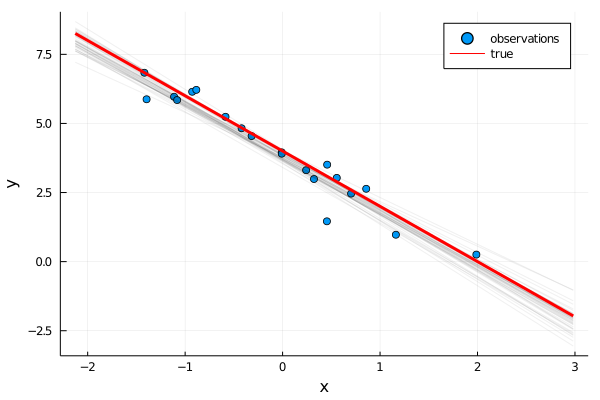

In [16]:
# Plot data
scatter(x, y, xlabel="x", ylabel="y", label="observations")

# Plot samples from posterior
xi = LinRange(minimum(x)*1.5, maximum(x)*1.5, 10)
β₀samples, β₁samples = sample(posterior, 10) |>
    x -> vec(Array(sample(posterior, 10)["β₀"])), 
         vec(Array(sample(posterior, 10)["β₁"]))

for (β₀, β₁) in zip(β₀samples, β₁samples)
    plot!(xi, linear_regression.(xi, β₀, β₁), 
          label=false, color=:black, alpha=0.06)
end

# Plot true regression line
LinRange(minimum(x)*1.5, maximum(x)*1.5, 50) |>
    x -> plot!(x, linear_regression.(x, β₀, β₁), label="true", lw=3, color=:red)